# Word embeddings neuronales

Word2Vec es una red neuronal que permite el aprendizaje de características en NLP. Es usado para crear *word embedding* cuando necesitamos una representación vectorial de los datos.

Los *word embedding* son representaciones vectoriales numéricas de texto que mantienen las relaciones semánticas y contextuales dentro de las palabras en el corpus de texto.

Utilizaremos los *word embedding* obtenidos del modelo Word2Vec, para luego alimentar un algoritmo de *clustering*. Cada *cluster* obtenido agrupará palabras que son semejantes.

In [26]:
%matplotlib inline

import spacy
import pickle
from utils import read_file, get_words_and_lemma, create_counter_word_vector
import gensim
from collections import Counter
from sklearn.cluster import KMeans
from sklearn import preprocessing
from gensim.models import Word2Vec
import numpy

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#parametrización
TEXT_FILE = 'lavoztextodump.txt'	# Text to be processed
ENCODING = 'utf8'
CLUSTERS_NUMBER = 40 # Number of clusters of words
MIN_FREQUENCY = 80	# Min word frequency to be considered
MIN_WORDS_COUNT_IN_SENT=10
POS_TAG= ['PROPN', 'ADJ', 'NOUN', 'VERB', 'ADV']

In [3]:
nlp = spacy.load('es_core_news_sm', disable=['parser', 'ner'])
nlp.max_length = 34886712

dataset = read_file(TEXT_FILE, ENCODING)
#doc = nlp(dataset)

filename = "trained/doc_npl_la_voz.pickle"
#fileObj = open(filename, 'wb')
#pickle.dump(doc, fileObj)
#fileObj.close()

with open(filename, 'rb') as f:
    doc = pickle.load(f)

Loading file lavoztextodump.txt


## Pre procesamiento

Se realizan los siguientes procesamientos:
1. Eliminación de *stop words*
2. Lematización utilizando Spacy
3. Eliminación de las palabras menos frecuentes
4. Identificación de biagramas y trigramas: los bigramas son dos palabras que aparecen juntas con frecuencia en el documento y los trigramas son tres palabras que aparecen juntas con frecuencia en el documento. Para hacer esto se uso Phrases de Gensim.
5. Eliminación de palabras no alfanuméricas
6. Solo se consideran palabras cuyo *part-of-speech* son un nombre propio, un adjetivo, un adverbio, un sustantivo o un verbo. [Ver *Universal POS tags*](https://universaldependencies.org/docs/u/pos/)

In [4]:
#identificación de las frecuencias de las palabras
words, words_lemma = get_words_and_lemma(doc, MIN_WORDS_COUNT_IN_SENT, POS_TAG)

counts = create_counter_word_vector(words_lemma)

sents = [sent for sent in doc.sents if len(sent) > MIN_WORDS_COUNT_IN_SENT] #Se eliminan oraciones con menos de 10 palabras

#se obtiene un array con las oraciones (en formato texto), cuyas palabras han pasado por un proceso de lematización y filtrado
doc_list = []
for indexsent, sent in enumerate(sents):
    resultArray = []
    for word in sent:
        if word.is_alpha and not word.is_stop and word.pos_ in POS_TAG and counts[word.lemma_] > MIN_FREQUENCY:
            resultArray.append(word.lemma_)
    if len(resultArray) > 0:
        doc_list.append(resultArray)


#Se convierte cada oración en una lista de palabras, eliminando las puntuaciones y caracteres innecesarios
#para esto usamos simple_preprocess () de Gensim
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(doc_list))

#print(data_words[:1])

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
#print(trigram_mod[bigram_mod[data_words[3]]])

# Define functions for bigrams and trigrams
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

# Form Bigrams
data_lemmatized = make_trigrams(data_words_bigrams)

#Filtrado de oraciones con minima cantidad de palabras
#data_lemmatized = []
#for temp in data_lemmatized_temp:
#    if len(temp) > 5:
#        data_lemmatized.append(temp)
#print(data_lemmatized[:1])


## Generación del modelo word2vec

Se generan las *word embedding* a través de Gensim. De esta forma obtenemos vectores de palabras.

In [18]:
model = Word2Vec(data_lemmatized,min_count=1)
vects = []
for word in model.wv.index_to_key:
    vects.append(model.wv[word])

vectors = numpy.array(vects)
#print("Matrix shape:",vectors.shape)

vocabulary= model.wv.index_to_key


Generating word vectors
Matrix shape: (1533, 100)
Vectors generated


## Clustering

Se genera el *clustering* utilizando un algoritmo de *k-means* a través de la librería *Scikit-learn*.

In [19]:
vectors = preprocessing.normalize(vectors)
km_model = KMeans(n_clusters=CLUSTERS_NUMBER)
km_model.fit(vectors)


Clustering started
Clustering finished


## Listado de clusters y sus palabras

Como resultado podemos observar que el *embedding* neuronal permite distinguir mucho mejor las palabras y su semejanza.

In [22]:
# Show results
c = Counter(sorted(km_model.labels_))
print("\nTotal clusters:",len(c))
for cluster in c:
    print ("Cluster#",cluster," - Total words:",c[cluster])

# Show top terms and words per cluster
print("Top words per cluster:")
print()

keysVocab = vocabulary
for n in range(len(c)):
    print("Cluster %d" % n)
    print("Words:", end='')
    word_indexs = [i for i,x in enumerate(list(km_model.labels_)) if x == n]
    for i in word_indexs:
        print(' %s' % keysVocab[i], end=',')
    print()
    print()


Total clusters: 40
Cluster# 0  - Total words: 42
Cluster# 1  - Total words: 35
Cluster# 2  - Total words: 26
Cluster# 3  - Total words: 37
Cluster# 4  - Total words: 27
Cluster# 5  - Total words: 45
Cluster# 6  - Total words: 24
Cluster# 7  - Total words: 67
Cluster# 8  - Total words: 55
Cluster# 9  - Total words: 73
Cluster# 10  - Total words: 61
Cluster# 11  - Total words: 36
Cluster# 12  - Total words: 37
Cluster# 13  - Total words: 15
Cluster# 14  - Total words: 22
Cluster# 15  - Total words: 14
Cluster# 16  - Total words: 26
Cluster# 17  - Total words: 15
Cluster# 18  - Total words: 62
Cluster# 19  - Total words: 53
Cluster# 20  - Total words: 34
Cluster# 21  - Total words: 38
Cluster# 22  - Total words: 34
Cluster# 23  - Total words: 27
Cluster# 24  - Total words: 18
Cluster# 25  - Total words: 28
Cluster# 26  - Total words: 22
Cluster# 27  - Total words: 19
Cluster# 28  - Total words: 57
Cluster# 29  - Total words: 56
Cluster# 30  - Total words: 25
Cluster# 31  - Total words: 3

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.8/site-pack

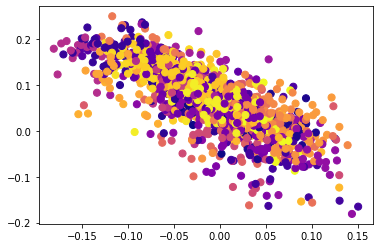

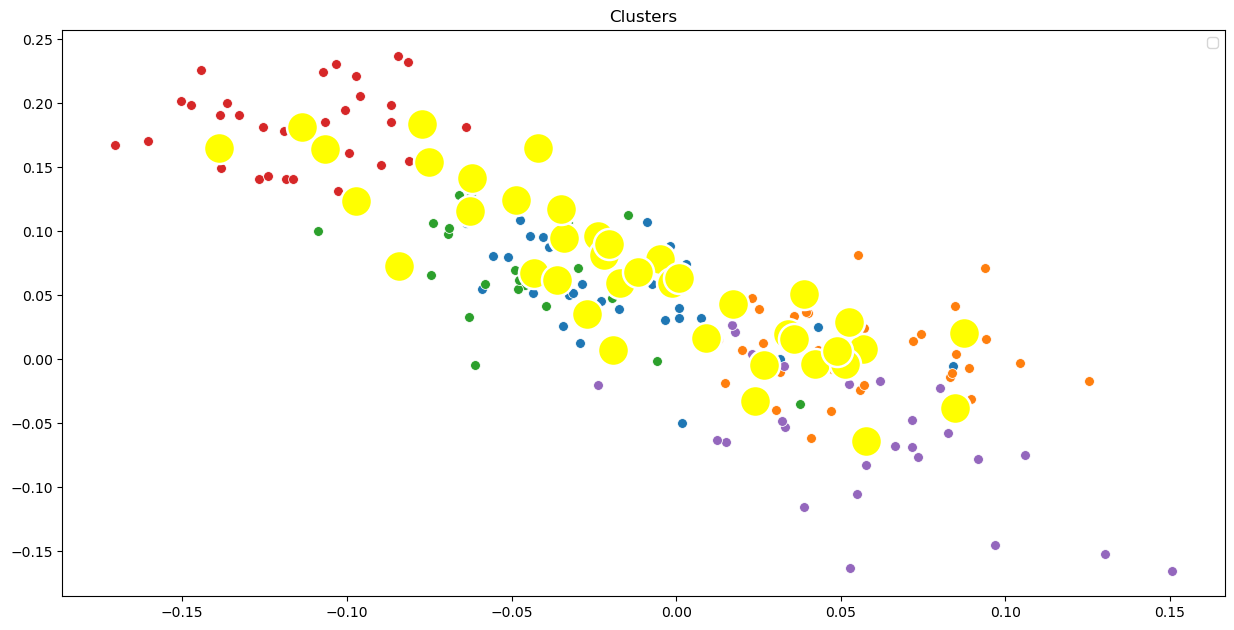

In [27]:
y_pred = km_model.predict(vectors)
plt.scatter(vectors[:, 0], vectors[:, 1], c=y_pred, s=50, cmap='plasma')
plt.rcParams.update({'figure.figsize':(10,7.5), 'figure.dpi':100})
plt.figure(figsize=(15,7.5))
sns.scatterplot(vectors[y_pred == 0, 0], vectors[y_pred == 0, 1],s=50)
sns.scatterplot(vectors[y_pred == 1, 0], vectors[y_pred == 1, 1],s=50)
sns.scatterplot(vectors[y_pred == 2, 0], vectors[y_pred == 2, 1],s=50)
sns.scatterplot(vectors[y_pred == 3, 0], vectors[y_pred == 3, 1],s=50)
sns.scatterplot(vectors[y_pred == 4, 0], vectors[y_pred == 4, 1],s=50)
sns.scatterplot(km_model.cluster_centers_[:, 0], km_model.cluster_centers_[:, 1],s=500,color='yellow')
plt.title('Clusters')
plt.legend()
plt.show()